# Algoritmo K-means (Core)
 **Descripción:**

El algoritmo K-means es uno de los métodos de agrupamiento más utilizados en análisis de datos y machine learning. Este algoritmo busca agrupar un conjunto de datos en K grupos o clusters, donde cada grupo está definido por un centroide. En esta actividad, utilizaremos el algoritmo K-means para analizar y segmentar clientes en función de su comportamiento de compra, utilizando el dataset «Mall Customer Segmentation Data» de Kaggle.

Enlace al dataset: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python



## Objetivo:

El objetivo de esta actividad es utilizar el algoritmo K-means para identificar diferentes grupos de clientes según su comportamiento de compra. El análisis de los clusters resultantes permitirá obtener una mejor comprensión de las características de los clientes, lo que puede ser útil para personalizar estrategias de marketing y mejorar la experiencia del cliente.


**Descripción del Algoritmo K-means**
K-means es un algoritmo de aprendizaje no supervisado que agrupa datos en K clusters o grupos, donde K es un número predefinido. Cada cluster se representa mediante un centroide, que es el promedio de todos los puntos de datos en ese grupo. El algoritmo tiene dos fases principales:

1. Asignación de clusters: Cada punto de datos se asigna al centroide más cercano.
2. Actualización de centroides: Se recalcula la posición de los centroides basándose en la media de los puntos de datos asignados a cada cluster.

Este proceso se repite hasta que los centroides no cambian significativamente o se alcanza un número máximo de iteraciones.



# Instrucciones

**Carga del Dataset:**
  - El dataset contiene información sobre clientes de un centro comercial, como su género, edad, ingresos anuales y puntaje de gasto.
  - Utiliza el archivo «Mall_Customers.csv» y cárgalo en tu entorno de trabajo.

In [1]:
# Agregar la carpeta 'src' al sys.path
import sys
import os

# Buscar 'src' automáticamente sin depender del nombre del proyecto
current_dir = os.getcwd()  # Directorio actual
while not os.path.exists(os.path.join(current_dir, "src")):
    current_dir = os.path.dirname(current_dir)  # Subir un nivel
    if current_dir == "/":  # Evitar bucles infinitos
        raise FileNotFoundError("No se encontró la carpeta 'src'. Verifica la estructura.")

src_path = os.path.join(current_dir, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve,auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from utils import cargar_datos_pd
from utils import dimensiones
from utils import ver_resumen_nulos
from utils import identificar_atipicos_IQR
from utils import ver_diccionario
from utils import imprimir_bigotes
from utils import plot_varianza
from utils import filtrar_columnas
from utils import desc
from utils import imprimir_bigotes_por_grupo
from utils import generar_diccionario
from utils import obtener_filas_no_numericas
from sklearn.metrics import silhouette_score


## Instrucciones:

## 1. Carga de datos:
  - Descarga y carga el dataset «Credit Card Data» de Kaggle. Realiza una exploración inicial de las variables y observa cómo se distribuyen.
  - Este dataset incluye información sobre los comportamientos de clientes de tarjetas de crédito. Variables como el monto total de gastos, el número de compras y el saldo de la cuenta son de interés para el agrupamiento.

In [3]:
# Mall_Customers.csv renombrado a train.csv
diccionario = '../../data/kaggle/core07/diccionario.csv'
ruta_archivo='../../data/kaggle/core07/train.csv'

df = cargar_datos_pd(ruta_archivo,sep=',', header=0)

Dataset cargado con éxito.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
ver_diccionario(diccionario)

╒═════╤════════════════════════╤════════╤═══════════════════════════════════════════════╤═══════════╕
│   # │ Columna                │ Tipo   │ Descripción                                   │ Ejemplo   │
╞═════╪════════════════════════╪════════╪═══════════════════════════════════════════════╪═══════════╡
│   1 │ CustomerID             │ int    │ Identificador único del cliente               │ 1         │
├─────┼────────────────────────┼────────┼───────────────────────────────────────────────┼───────────┤
│   2 │ Gender                 │ object │ Género del cliente                            │ Male      │
├─────┼────────────────────────┼────────┼───────────────────────────────────────────────┼───────────┤
│   3 │ Age                    │ int    │ Edad del cliente en años                      │ 32        │
├─────┼────────────────────────┼────────┼───────────────────────────────────────────────┼───────────┤
│   4 │ Annual Income (k$)     │ int    │ Ingreso anual del cliente en miles de dó

In [7]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
CustomerID,200,0,0.0
Gender,200,0,0.0
Age,200,0,0.0
Annual Income (k$),200,0,0.0
Spending Score (1-100),200,0,0.0


## No hay nulos.

Ya no hay nulos.

## 2. Selección de Variables:
  - Para este análisis, selecciona las variables ‘Annual Income (k$)’ y ‘Spending Score (1-100)’, ya que representan características importantes relacionadas con el comportamiento de compra.

## 3. Implementación de K-means:
  - Aplica el algoritmo K-means utilizando diferentes valores de K (por ejemplo, K = 3, 4, 5) y observa cómo se agrupan los clientes.
  - Visualiza los resultados utilizando gráficos de dispersión que representen los clusters y los centroides.
 

Vamos a implementar de forma sencilla el Modelo y encontrar el mejor K

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes
columnas_relevantes = ['Annual Income (k$)', 'Spending Score (1-100)']

# Estandarizar las columnas seleccionadas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columnas_relevantes])

# Visualización de los primeros registros estandarizados (opcional)
print(pd.DataFrame(df_scaled, columns=columnas_relevantes).head())


   Annual Income (k$)  Spending Score (1-100)
0           -1.738999               -0.434801
1           -1.738999                1.195704
2           -1.700830               -1.715913
3           -1.700830                1.040418
4           -1.662660               -0.395980


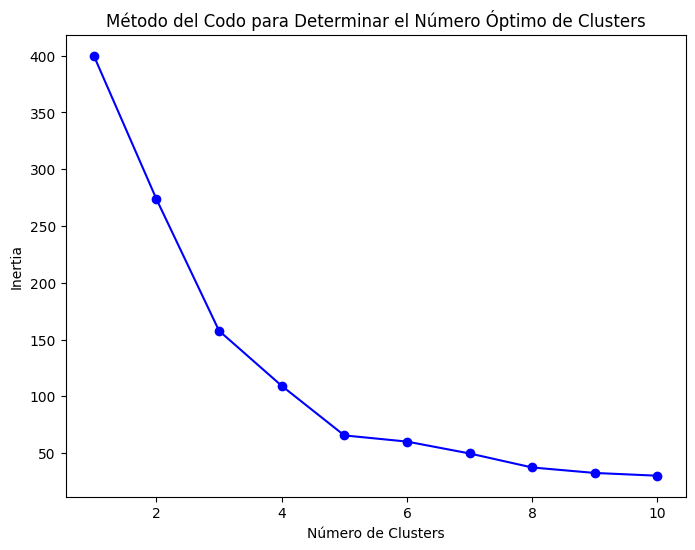

In [9]:
# Método del codo: calcular la inertia para diferentes valores de K
inertia = []
range_k = range(1, 11)  # Probar con K de 1 a 10

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range_k, inertia, marker='o', color='b')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()


In [10]:
ver_diccionario(diccionario)

╒═════╤════════════════════════╤════════╤═══════════════════════════════════════════════╤═══════════╕
│   # │ Columna                │ Tipo   │ Descripción                                   │ Ejemplo   │
╞═════╪════════════════════════╪════════╪═══════════════════════════════════════════════╪═══════════╡
│   1 │ CustomerID             │ int    │ Identificador único del cliente               │ 1         │
├─────┼────────────────────────┼────────┼───────────────────────────────────────────────┼───────────┤
│   2 │ Gender                 │ object │ Género del cliente                            │ Male      │
├─────┼────────────────────────┼────────┼───────────────────────────────────────────────┼───────────┤
│   3 │ Age                    │ int    │ Edad del cliente en años                      │ 32        │
├─────┼────────────────────────┼────────┼───────────────────────────────────────────────┼───────────┤
│   4 │ Annual Income (k$)     │ int    │ Ingreso anual del cliente en miles de dó

In [25]:
# Número óptimo de clusters (determinado visualmente del gráfico)
k_optimo = 5  # Ajusta este valor según el gráfico del codo

# Aplicar K-means
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualizar los resultados de los clusters
print(df[['CustomerID', 'Gender', 'Age', 'Cluster']].head())


   CustomerID  Gender  Age  Cluster
0           1    Male   19        4
1           2    Male   21        2
2           3  Female   20        4
3           4  Female   23        2
4           5  Female   31        4


In [26]:
# Calcular el Silhouette Score
sil_score = silhouette_score(df_scaled, df['Cluster'])
print(f'Silhouette Score: {sil_score}')


Silhouette Score: 0.5546571631111091


## El mejor K de acuerdo al Silhouette Score es CINCO

Ahora procedemos con los puntos solicitados.
  - Aplica el algoritmo K-means utilizando diferentes valores de K (por ejemplo, K = 3, 4, 5) y observa cómo se agrupan los clientes.
  - Visualiza los resultados utilizando gráficos de dispersión que representen los clusters y los centroides.

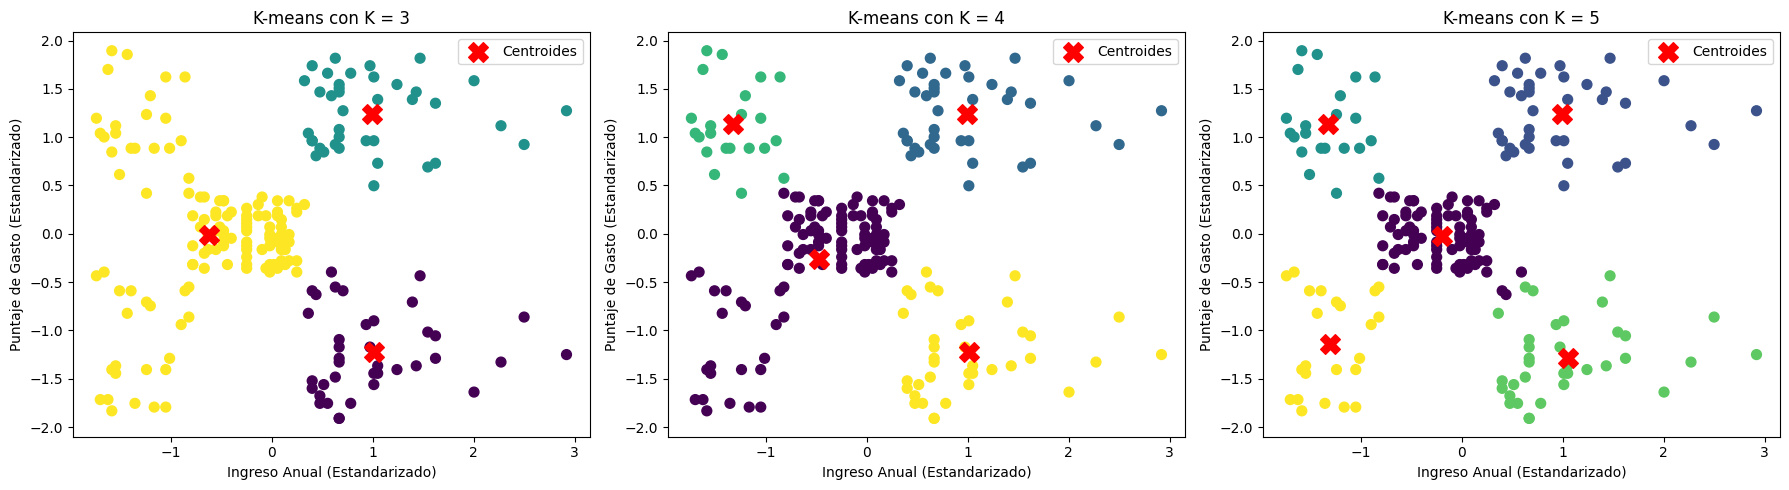

In [27]:
# Función para aplicar K-means con diferentes valores de K y graficar resultados
def aplicar_kmeans_y_visualizar(X, k_values):
    plt.figure(figsize=(18, 5))
    
    for i, k in enumerate(k_values):
        # Aplicar el algoritmo K-means
        kmeans = KMeans(n_clusters=k, random_state=42)
        y_kmeans = kmeans.fit_predict(X)
        
        # Obtener los centroides
        centroids = kmeans.cluster_centers_
        
        # Gráfico de dispersión de los clusters
        plt.subplot(1, len(k_values), i+1)
        plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=50)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
        plt.title(f"K-means con K = {k}")
        plt.xlabel('Ingreso Anual (Estandarizado)')
        plt.ylabel('Puntaje de Gasto (Estandarizado)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Aplicar la función con diferentes valores de K
k_values = [3, 4, 5]
aplicar_kmeans_y_visualizar(df_scaled, k_values)

## 4. Elbow Method:
  - Utiliza el método del codo para identificar el número óptimo de clusters. Este método consiste en ejecutar K-means con diferentes valores de K y calcular la suma de errores cuadráticos (SSE). El valor óptimo de K se encuentra donde se produce una disminución significativa en el SSE.

C:\Users\edgar\AppData\Local\Temp\ipykernel_21308\1713708764.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, sse, 'bo-', color='blue', markersize=8)


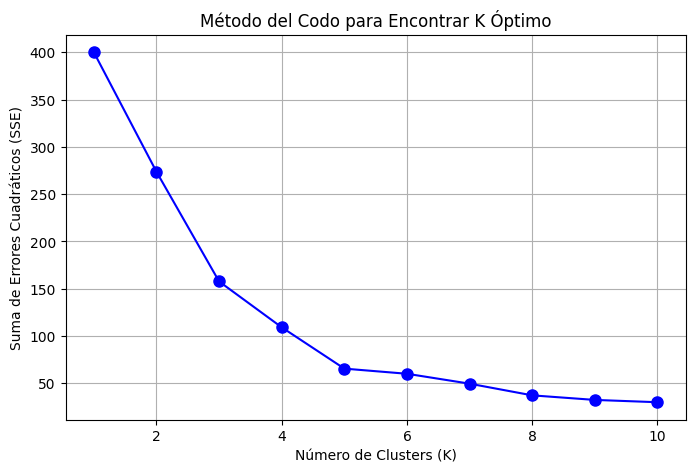

In [28]:

# Método del codo (Elbow Method) para encontrar el número óptimo de clusters
sse = []  # Lista para almacenar la suma de errores cuadráticos (SSE)
k_values = range(1, 11)  # Probar valores de K desde 1 hasta 10

# Calcular SSE para cada valor de K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)  # inertia_ es la SSE para el modelo actual

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, 'bo-', color='blue', markersize=8)
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.grid()
plt.show()


## Wow, este mapa es mejor del que hice más arriba, me gusta mas.
## Aquí se ve mejor que el CINCO es el mejor K.

In [33]:
# Número óptimo de clusters (determinado visualmente del gráfico)
k_optimo = 5  # Ajusta este valor según el gráfico del codo

# Aplicar K-means
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualizar los resultados de los clusters
print(df[['CustomerID', 'Gender', 'Age', 'Cluster']].head())

   CustomerID  Gender  Age  Cluster
0           1    Male   19        4
1           2    Male   21        2
2           3  Female   20        4
3           4  Female   23        2
4           5  Female   31        4


In [34]:
df_kmeans = df.drop(columns=['CustomerID'])

for cluster in df_kmeans['Cluster'].unique():
    print(f"Estadísticas del Cluster {cluster}:")
    print(df_kmeans[df_kmeans['Cluster'] == cluster].describe())


Estadísticas del Cluster 4:
             Age  Annual Income (k$)  Spending Score (1-100)  Cluster
count  23.000000           23.000000               23.000000     23.0
mean   45.217391           26.304348               20.913043      4.0
std    13.228607            7.893811               13.017167      0.0
min    19.000000           15.000000                3.000000      4.0
25%    35.500000           19.500000                9.500000      4.0
50%    46.000000           25.000000               17.000000      4.0
75%    53.500000           33.000000               33.500000      4.0
max    67.000000           39.000000               40.000000      4.0
Estadísticas del Cluster 2:
             Age  Annual Income (k$)  Spending Score (1-100)  Cluster
count  22.000000           22.000000               22.000000     22.0
mean   25.272727           25.727273               79.363636      2.0
std     5.257030            7.566731               10.504174      0.0
min    18.000000           15.0000

## **Interpretación de Clusters**

| **Cluster** | **Resumen de Características**                                                                                       | **Estrategia de Marketing**                                                                                           |
|-------------|---------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|
| **0**       | - **Edad promedio:** 43 años<br> - **Ingreso anual promedio:** $55k<br> - **Spending Score promedio:** 50<br> - Grupo equilibrado. | - Clientes de ingresos medios y gasto moderado.<br> - Ofertas generales y descuentos estacionales.                   |
| **1**       | - **Edad promedio:** 33 años<br> - **Ingreso anual promedio:** $86k<br> - **Spending Score promedio:** 82<br> - Alta disposición a gastar. | - Clientes con altos ingresos y alto gasto.<br> - Promociones premium y paquetes exclusivos.                         |
| **2**       | - **Edad promedio:** 25 años<br> - **Ingreso anual promedio:** $26k<br> - **Spending Score promedio:** 79<br> - Jóvenes con alto gasto. | - Jóvenes con ingresos bajos pero alto consumo.<br> - Campañas dirigidas a experiencias, productos económicos.       |
| **3**       | - **Edad promedio:** 41 años<br> - **Ingreso anual promedio:** $88k<br> - **Spending Score promedio:** 17<br> - Altos ingresos, bajo gasto. | - Clientes de ingresos altos pero baja disposición a gastar.<br> - Estrategias de fidelización y ofertas personalizadas. |
| **4**       | - **Edad promedio:** 45 años<br> - **Ingreso anual promedio:** $26k<br> - **Spending Score promedio:** 21<br> - Bajos ingresos y bajo gasto. | - Clientes menos activos en compras.<br> - Descuentos agresivos, productos básicos y programas de retención.         |

---

## **Resumen General**

1. **Cluster 1** y **Cluster 2**: Representan a los clientes más activos en términos de gasto (alta puntuación de Spending Score).  
   - Estos grupos son ideales para **ofertas exclusivas** o **campañas orientadas a retener clientes de alto valor**.

2. **Cluster 0**: Clientes con comportamiento promedio en ingresos y gasto.  
   - Pueden ser objetivo de campañas **generalistas** y **descuentos estacionales**.

3. **Cluster 3**: Clientes con altos ingresos pero baja disposición a gastar.  
   - Aquí se puede trabajar con **campañas de fidelización** o **paquetes personalizados** para incentivar el gasto.

4. **Cluster 4**: Clientes con bajos ingresos y bajo gasto.  
   - Ofertas **económicas** y productos básicos pueden atraer a este segmento.


## **Análisis de Resultados**

Los resultados del análisis de clustering proporcionan una visión clara sobre cómo los diferentes grupos de clientes se agrupan en función de sus características. A continuación, se discuten los insights clave obtenidos de cada cluster:

### **Cluster 0: Ingresos medios y gasto moderado**
- **Insight principal**: Este cluster está compuesto por clientes con una **edad promedio de 43 años**, **ingresos anuales de $55k**, y un **Spending Score moderado** de 50. Los clientes de este grupo muestran un comportamiento equilibrado en términos de ingresos y gasto.
- **Patrones**: Este grupo podría estar compuesto por personas en etapas intermedias de su vida laboral, con ingresos estables pero no necesariamente dispuestos a gastar en exceso.
- **Estrategia**: Para este grupo, se pueden diseñar **ofertas generales**, **promociones estacionales** y **descuentos familiares**. Es importante mantener su interés sin ser demasiado agresivo con las promociones.

### **Cluster 1: Altos ingresos y alto gasto**
- **Insight principal**: Los clientes en este grupo tienen una **edad promedio de 33 años**, **ingresos anuales de $86k**, y un **Spending Score alto** de 82. Este cluster está compuesto por personas con **alta disposición a gastar**.
- **Patrones**: Los miembros de este grupo son probablemente jóvenes profesionales con un alto poder adquisitivo y una mentalidad más abierta a gastar en productos y servicios de alto valor.
- **Estrategia**: Este grupo es ideal para **ofertas premium**, **productos exclusivos**, y **paquetes personalizados**. Es importante mantener su interés mediante **promociones exclusivas** y **recompensas por fidelidad**.

### **Cluster 2: Jóvenes con alto gasto y bajos ingresos**
- **Insight principal**: El grupo está compuesto principalmente por clientes **jóvenes (promedio de 25 años)** con **ingresos anuales más bajos** de $26k, pero un **gasto relativamente alto** con un **Spending Score de 79**.
- **Patrones**: Estos clientes tienen una mentalidad de consumo fuerte, a pesar de no contar con ingresos altos. Pueden estar buscando productos y servicios que ofrezcan una **buena relación calidad-precio**.
- **Estrategia**: Para este grupo, es recomendable ofrecer **productos económicos**, **descuentos atractivos**, y **experiencias personalizadas**. Las **campañas de marketing digital** y los **productos de bajo costo** pueden ser muy efectivos.

### **Cluster 3: Altos ingresos y bajo gasto**
- **Insight principal**: Este cluster incluye clientes con **ingresos anuales altos** de $88k y una **baja puntuación de gasto** de 17. La **edad promedio** es de 41 años, lo que sugiere que son personas más maduras que, a pesar de tener un alto poder adquisitivo, no gastan mucho.
- **Patrones**: Estos clientes pueden tener un enfoque más conservador respecto al gasto, lo que puede deberse a preferencias personales, prioridades familiares, o simplemente un enfoque más racional en sus decisiones de compra.
- **Estrategia**: Se podrían implementar **estrategias de fidelización** para este grupo, como **ofertas personalizadas**, **paquetes exclusivos** o **beneficios de largo plazo**. Además, **educación financiera** o **promociones dirigidas** podrían incentivar un mayor gasto.

### **Cluster 4: Bajos ingresos y bajo gasto**
- **Insight principal**: Los clientes en este grupo tienen una **edad promedio de 45 años**, **ingresos anuales de $26k**, y un **gasto bajo** (Spending Score de 21). Este es el grupo más conservador en términos de consumo.
- **Patrones**: Este grupo muestra un comportamiento de consumo muy cauteloso, probablemente debido a limitaciones económicas. Podrían estar más interesados en productos básicos y esenciales.
- **Estrategia**: Para este grupo, se pueden ofrecer **descuentos agresivos**, **productos básicos a precios bajos**, y **programas de fidelización** que fomenten la repetición de compras a precios accesibles.

### **Conclusión General**
1. **Diversidad de Comportamientos**: Los clientes no son homogéneos, lo que sugiere que las estrategias de marketing deben ser **altamente segmentadas** para abordar las diferentes necesidades y comportamientos de compra de cada grupo.
2. **Clientes Dispuestos a Gastar**: Los **clusters 1 y 2** son los más rentables desde el punto de vista del marketing, ya que muestran una alta disposición a gastar. Sin embargo, es importante ofrecerles **productos exclusivos** y mantener su **interés con promociones personalizadas**.
3. **Clientes Conservadores**: Los **clusters 0, 3 y 4** tienen ingresos medios a altos, pero con un comportamiento de gasto más conservador. Las **estrategias de fidelización**, **descuentos selectivos** y **paquetes personalizados** pueden ser útiles para estos grupos.
